In [1]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsDataset
from pathlib import Path

import matplotlib.pyplot as plt

from dtw import dtw

In [2]:
# Dataset loader
datapath = Path('data')
dataset = TsDataset(datapath/'CaseI-Attacks without any change.csv')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                        shuffle=True, num_workers=4)
print("The size of the dataset is: ", dataset.data_normal.size(), dataset.data_abnormal.size())

The size of the dataset is:  torch.Size([33, 576]) torch.Size([33, 15, 576])


In [3]:
normal_dim = dataset.data_normal.size(1)
abnormal_dim = dataset.data_abnormal.size(2)
in_dim = dataset.__len__()

In [4]:
G_AB = LSTMGenerator(normal_dim, normal_dim)
G_BA = LSTMGenerator(abnormal_dim, abnormal_dim)
D_A = LSTMDiscriminator(normal_dim)
D_B = LSTMDiscriminator(abnormal_dim)

In [5]:
G_AB.load_state_dict(torch.load("saved_models/cyber/G_AB_190.pth"))
G_BA.load_state_dict(torch.load("saved_models/cyber/G_BA_190.pth"))
D_A.load_state_dict(torch.load("saved_models/cyber/D_A_190.pth"))
D_B.load_state_dict(torch.load("saved_models/cyber/D_B_190.pth"))

<All keys matched successfully>

In [6]:
G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMDiscriminator(
  (lstm): LSTM(576, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
dataset.data_normal.size()

torch.Size([33, 576])

In [8]:
threshold = 6.0

In [9]:
dataset_test = TsDataset(datapath/'CaseII.csv')
dataset_test.data_normal.size()

torch.Size([33, 144])

Output size: torch.Size([33, 1, 576]) 	 Output Back size: torch.Size([33, 1, 576])
+ 1.1046712468898758
+ 1.0712695378433623
+ 1.0780540437339154
+ 1.080140382941859
+ 1.072658961524924
+ 1.0751795947576233
+ 1.0751795947576233
+ 1.072278123373348
+ 1.0712033901735796
+ 1.0731579056139373
+ 1.0720394349720586
+ 1.0734910672642373
+ 1.0618854052531896
+ 1.498584868063007
+ 2.052186987837585
+ 2.218067237263312
+ 2.0372990742020316
+ 2.2071872141798297
+ 1.113742997499156
+ 1.5352080820174876
+ 2.9198212367588265
+ 5.958225287644663
+ 2.0638337102041024
+ 3.1976733237873414
+ 4.0344775981599765
- 6.351311732524543
+ 1.4518999365828849
+ 2.9198212367588265
+ 1.6233352033925357
- 10.198835911228993
+ 1.1493125848255397
+ 1.3256800610261736
+ 1.9838926837771562


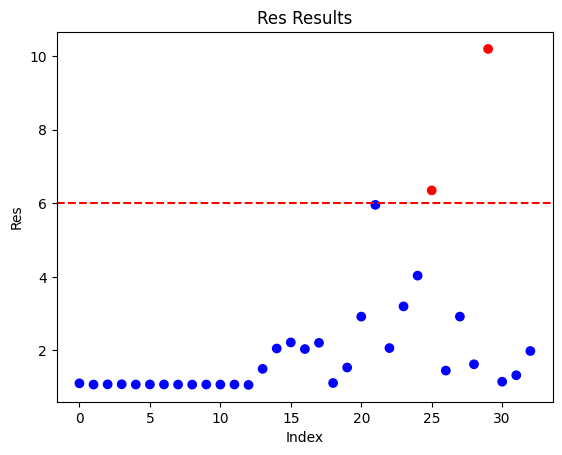

In [10]:
with torch.no_grad():
    output = G_AB(dataset_test.data_normal.repeat(1, 4).unsqueeze(1))
    output_back = G_BA(output)
print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")


# for i in range(output.size(0)):
#     plt.plot(output[i, 0, :].numpy())
#     plt.plot(output_back[i, 0, :].numpy())
#     plt.plot(dataset_test.data_normal[i, :].numpy())
#     plt.legend(['Generated', 'Generated Back', 'Original'])
#     plt.savefig(f'cyber_result/forward/output_{i}.png')
#     plt.close()

#     dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), dataset_test.data_normal[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
#     dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
#     dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), dataset_test.data_normal[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
#     res = (dist2+dist3)/dist1
#     print("+" if res < threshold else "-", res)

res_list = []
for i in range(output.size(0)):
    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), dataset_test.data_normal[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), dataset_test.data_normal[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    res = (dist2+dist3)/dist1
    print("+" if res < threshold else "-", res)
    res_list.append(res)

plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(res_list)), res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Res Results')
plt.show()

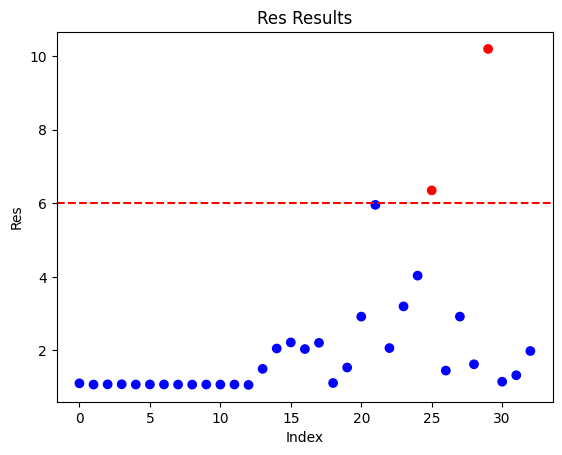

In [11]:
plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(res_list)), res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Res Results')
plt.show()

---

In [12]:
dataset_test.data_abnormal.size()

torch.Size([33, 15, 144])

In [13]:
data_abnormal_test = dataset.data_abnormal[:,4,:]
data_abnormal_test.size()

torch.Size([33, 576])

In [14]:
with torch.no_grad():
    output = G_AB(data_abnormal_test.unsqueeze(1))
    output_back = G_BA(output)

- 13.645967250604835
- 19.17602177771924
- 15.715321049289651
- 13.852028444806274
+ 4.060437273986812
- 18.535190994650687
- 18.535190994650687
- 16.428836745949006
- 16.19938056625685
- 16.560803521692588
- 15.749524010761304
- 15.69403178385037
- 14.456757589183818
+ 1.2139990066117166
+ 5.612135560882262
+ 5.778840639539935
- 6.360790818638663
+ 4.461466266765887
+ 5.633340903930642
+ 1.6429144496737427
- 6.749516742614806
- 12.159520171130774
+ 1.5686888937689831
+ 0.9425672816094716
+ 0.7903321402786243
+ 0.994394317543922
- 10.374405431651637
- 6.749516742614806
- 12.833833992909339
- 12.978556227023672
- 14.898392397115806
- 16.646282757505123
- 9.955132545407885


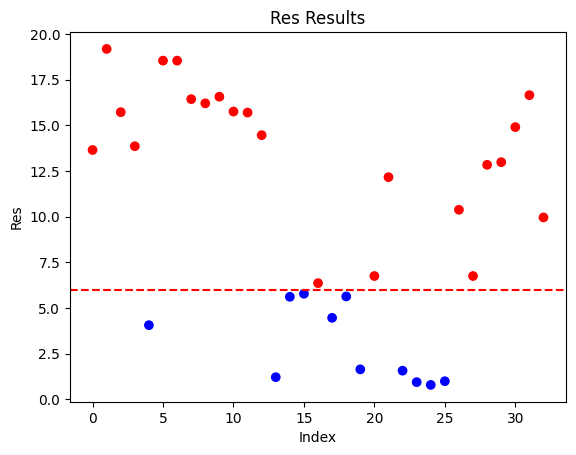

In [15]:
res_list = []
for i in range(output.size(0)):
    plt.plot(output[i, 0, :].numpy())
    plt.plot(output_back[i, 0, :].numpy())
    plt.plot(data_abnormal_test[i, :].numpy())
    plt.legend(['Generated', 'Generated Back', 'Original'])
    plt.savefig(f'cyber_result/detection/output_{i}.png')
    plt.close()

    dist1, cost, acc, path = dtw(output[i,0,:].reshape(-1, 1), data_abnormal_test[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist2, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), output[i,0,:].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    dist3, cost, acc, path = dtw(output_back[i,0,:].reshape(-1, 1), data_abnormal_test[i, :].reshape(-1, 1), dist=lambda x, y: np.linalg.norm(x - y, ord=1)) 
    res = (dist2+dist3)/dist1   
    print("+" if res < threshold else "-", res)
    res_list.append(res)

plt.figure()
# Assuming res_list and threshold are defined as in your code
colors = ['red' if res > threshold else 'blue' for res in res_list]
# Scatter plot with individual colors for each point
plt.scatter(range(len(res_list)), res_list, color=colors)
plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Res')
plt.title('Res Results')
plt.show()